## Introduction

In [2]:
library(tidyverse)
library(broom)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(cowplot)



── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-2



In [10]:
steam_games <- read_csv('https://raw.githubusercontent.com/DanielZCode/STAT-301-Project/main/games-features-edit.csv')
head(steam_games) # preview of the data
nrow(steam_games) # 12624 data points (games)
colnames(steam_games) #variables
length(colnames(steam_games)) #number of variables == 19


Rows: 12624 Columns: 19
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ResponseName, ReleaseDate
dbl  (3): Metacritic, RecommendationCount, PriceInitial
lgl (14): IsFree, GenreIsNonGame, GenreIsIndie, GenreIsAction, GenreIsAdvent...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ResponseName,ReleaseDate,Metacritic,RecommendationCount,IsFree,GenreIsNonGame,GenreIsIndie,GenreIsAction,GenreIsAdventure,GenreIsCasual,GenreIsStrategy,GenreIsRPG,GenreIsSimulation,GenreIsEarlyAccess,GenreIsFreeToPlay,GenreIsSports,GenreIsRacing,GenreIsMassivelyMultiplayer,PriceInitial
<chr>,<chr>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>
Counter-Strike,Nov 1 2000,88,68991,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,9.99
Team Fortress Classic,Apr 1 1999,0,2439,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,4.99
Day of Defeat,May 1 2003,79,2319,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,4.99
Deathmatch Classic,Jun 1 2001,0,888,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,4.99
Half-Life: Opposing Force,Nov 1 1999,0,2934,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,4.99
Ricochet,Nov 1 2000,0,1965,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,4.99


[1] 12624

[1] "ResponseName"                "ReleaseDate"                
 [3] "Metacritic"                  "RecommendationCount"        
 [5] "IsFree"                      "GenreIsNonGame"             
 [7] "GenreIsIndie"                "GenreIsAction"              
 [9] "GenreIsAdventure"            "GenreIsCasual"              
[11] "GenreIsStrategy"             "GenreIsRPG"                 
[13] "GenreIsSimulation"           "GenreIsEarlyAccess"         
[15] "GenreIsFreeToPlay"           "GenreIsSports"              
[17] "GenreIsRacing"               "GenreIsMassivelyMultiplayer"
[19] "PriceInitial"

[1] 19

### Wrangling 
In order to correctly use the `ReleaseDate` variable, we will need to convert it from its current character-based format to a numerical value. Although it would be convenient to convert this variable year that the game was released, that would not be a true continuous variable since years are discrete. Hence, we will need to convert `ReleaseDate` to a continuous variable representing the number of days passed since January 1st, 1970. This is a common representation of time in computers. 

In addition, we will filter the data for missing values, and in particular check that a game's `Metacritic` score is not 0, because that indicates a lack of reviews and an unplayed game. We will also filter only for games that were released after 1970. 

In [11]:
steam_games$ReleaseDate <- steam_games$ReleaseDate %>% as.Date(format="%b%d%Y") %>%  as.numeric()


steam_games <- steam_games %>% drop_na() %>% filter(Metacritic > 0, ReleaseDate > 0)


head(steam_games)
nrow(steam_games)



ResponseName,ReleaseDate,Metacritic,RecommendationCount,IsFree,GenreIsNonGame,GenreIsIndie,GenreIsAction,GenreIsAdventure,GenreIsCasual,GenreIsStrategy,GenreIsRPG,GenreIsSimulation,GenreIsEarlyAccess,GenreIsFreeToPlay,GenreIsSports,GenreIsRacing,GenreIsMassivelyMultiplayer,PriceInitial
<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>
Counter-Strike,11262,88,68991,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,9.99
Day of Defeat,12173,79,2319,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,4.99
Half-Life,10538,96,12486,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,9.99
Counter-Strike: Condition Zero,12478,65,7067,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,9.99
Counter-Strike: Condition Zero,12478,65,7067,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,9.99
Half-Life: Blue Shift,11474,71,2219,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,4.99


[1] 2241

### Exploratory Analysis
Below are some estimates of our response variable, `Metacritic`, and its relation to other variables.

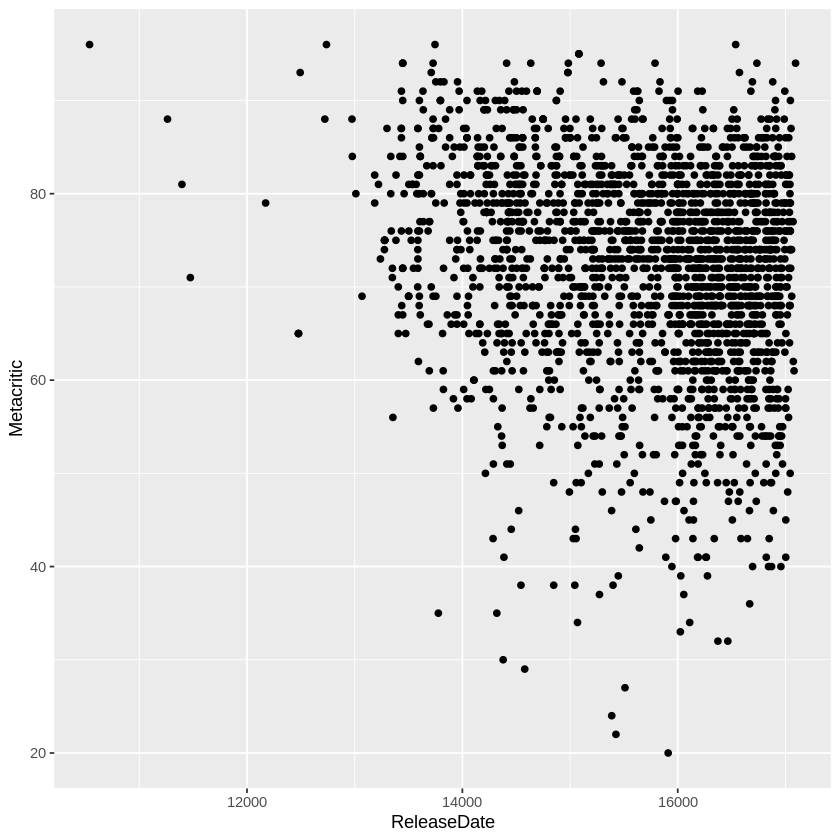

In [12]:
steam_games_metacritic_releasedate_plot <- steam_games %>% ggplot() +
    geom_point(aes(x = ReleaseDate, y = Metacritic))  
steam_games_metacritic_releasedate_plot

#### Figure 1. Metacritic Score vs. Release Date

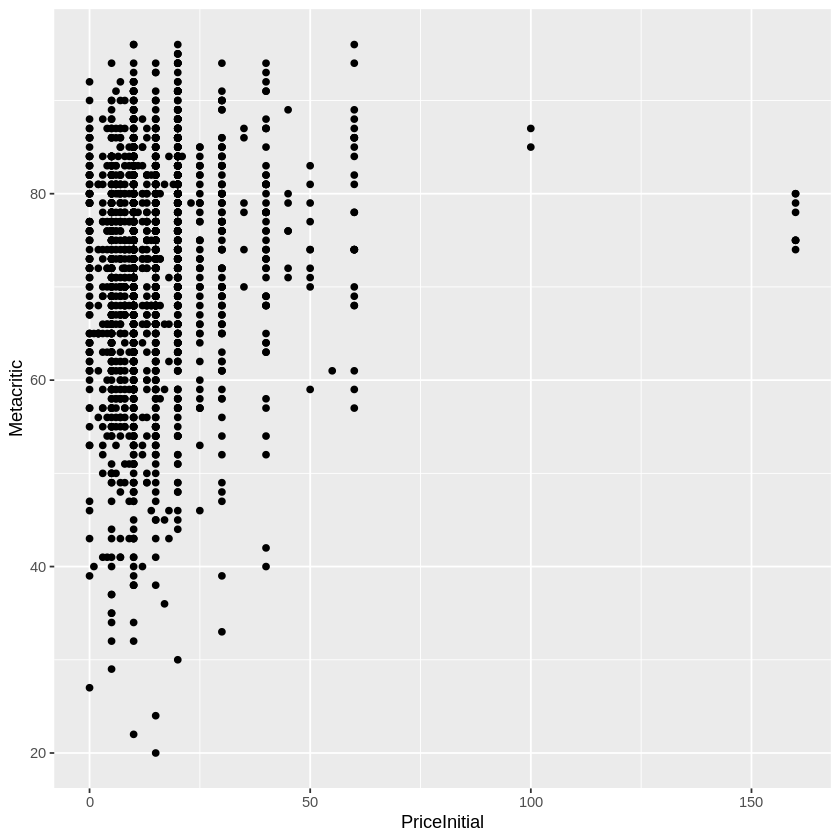

In [13]:
steam_games_metacritic_price_plot <- steam_games %>% ggplot() +
    geom_point(aes(x = PriceInitial, y = Metacritic))  
steam_games_metacritic_price_plot

#### Figure 2. Metacritic Score vs Price